# Gaussian Mixture Models

(Important note: this text is my interpretation).

Gaussians are placed in the dataset accounting for class values. The loacation and parameters of these Gaussians is optimized so that they optimally predict the class of a point in the feature space. In addition to the prediction, we can query the final Gaussian parameters: mean, covariances, etc.

There are two implementations in Scikit-Learn with an almost identical API:
1. `sklearn.mixture.GaussianMixture`
2. `sklearn.mixture.BayesianGaussianMixture`

The first is the simplest method: we set `n_components` Gaussian components and the set parameters are optimized; we can define how the variance of the Gaussians is modelled:
- `spherical`: each component has its own single variance: `n_components` covariances
- `diag`: each component has its own diagonal covariance matrix: `n_components` x `n_features` covariances
- `tied`: all components share the same general covariance matrix
- `full`: each component has its own general covariance matrix

As I understand, the first method would have problems when we have a concave dataset in which several isolated chunks of a class are inside bigger clusters of another class -- then, `n_components` cannot be approximated with the number of classes. For that, the second method is used, which is the **Variational Bayesian estimation of a Gaussian Mixture**. Here, we set a higher `n_components` and the optimal number of actual components is determined. *Is that really so?* I observe that the second method takes longer and that for this dataset increasing `n_components` does not yield any improvements...

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [103]:
# Load and explore dataset
# Dataset of 400 customers.
# Each one as 2 features: age and estimated salary.
# The target is whether they bought an SUV or not.
# The classifier should predict whether a customer would buy an SUV or not in odrder to show him the ad.
df = pd.read_csv('data/Social_Network_Ads.csv')

In [104]:
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
Age                400 non-null int64
EstimatedSalary    400 non-null int64
Purchased          400 non-null int64
dtypes: int64(3)
memory usage: 9.5 KB


In [106]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


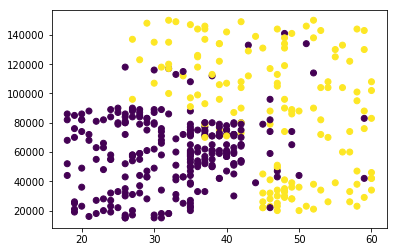

In [107]:
plt.scatter(df['Age'],df['EstimatedSalary'],c=df['Purchased'])

In [108]:
# Crate the train/test splits
X = df.drop('Purchased',axis=1)
y = df['Purchased']

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [111]:
# Scale data!
# The scaling range should be given by the train split only
# The test split should be transformed to that scaling range
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
# Load and instantiate classifier
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
# I understand:
# Components are the Gaussian blobs set in the feature space
# I we have two classes, two components makes sense;
# however, I'm assuming there are not extremey concave blobs in the feature space...
# Covariance type defines how the variance is modelled in the Gaussian blob
# - 'spherical': only one covariance value for each component: variance or s^2
# - 'diag': for each component n_feature covariances: diagonal covariance matrix, one variance for each feature dimension
# - 'full': the full covariance matrix n_feature x n_feature for each component
gm = GaussianMixture(n_components=2,covariance_type='diag')
#gm = BayesianGaussianMixture(n_components=2,covariance_type='diag')

In [113]:
# Fit/Train
gm.fit(X_train, y_train)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [114]:
# Predict/Infer
predictions = gm.predict(X_test)

In [115]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.73      0.84        73
          1       0.70      1.00      0.82        47

avg / total       0.88      0.83      0.83       120

[[53 20]
 [ 0 47]]


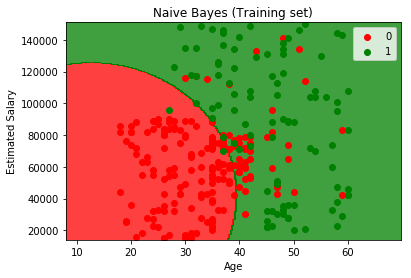

In [116]:
# Visualization: Given any
#     classifier
#     X_train, y_train
#     scaler
#     dataset consisting of samples with 2 features and 2 classes
# we can plot the prediction regions by sampling the feature space in pixels
# and predicting their class with the classifier      
from matplotlib.colors import ListedColormap
X_set, y_set = scaler.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))
plt.contourf(X1, X2, gm.predict(scaler.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Naive Bayes (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

In [117]:
# Extract component weights
gm.weights_

array([ 0.44534653,  0.55465347])

In [118]:
# Extract component means
gm.means_

array([[-0.67866096, -0.34222992],
       [ 0.54491554,  0.27478581]])

In [119]:
# Extract component covariances
gm.covariances_

array([[ 0.45556784,  0.53971045],
       [ 0.7703955 ,  1.20003376]])